In [1]:
# imports
%pylab inline
import numpy.random as random
import scipy.stats as stats


Populating the interactive namespace from numpy and matplotlib


Set up two sets of 15 values from normal distributions, N(0,1) or N(1,1):

In [2]:
ndata=15
data1=random.randn(ndata)
data2=random.randn(ndata)+1.

print(data1)


[-1.39104803 -0.69705091  0.27919595  3.26692649 -1.62447961 -1.06911023
  0.22746115 -1.10589435  0.80320129 -0.84961078  1.15357568 -0.68927775
  1.65778085  1.59889493 -0.47464469]


__Using the below code box, plot histograms of data1 and data2 with the same binning enforced (don't allow automatic binning); can you see the difference by eye?__

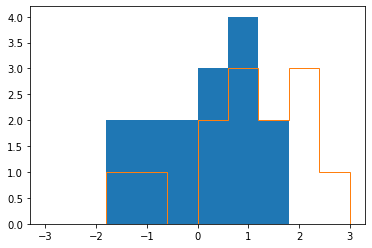

In [21]:
plt.hist(data1, bins=linspace(-3,3,11))
plt.hist(data2, bins=linspace(-3,3,11), histtype='step')
plt.show()

Now, let's calculate confidence intervals for the mean of each sample.  __Add code to calculate the std. deviation of the mean for each sample, `sigma1` and `sigma2`.__ (Reminder: _sample_ std. deviation is `np.std` with `ddof=1`).

In [3]:
mean1=np.mean(data1)
mean2=np.mean(data2)

sigma1=np.std(data1, ddof=1)/np.sqrt(ndata) # want the standard deviation of the mean of data1
sigma2=np.std(data2, ddof=1)/np.sqrt(ndata) # want the standard deviation of the mean of data2


print(f'means: {mean1:.4f}, {mean2:.4f}')
print(f'sigmas {sigma1:.4f} {sigma2:.4f}')

tfactor=stats.t.ppf(1-0.025,ndata-1)
print('Confidence Interval 1: ',mean1-tfactor*sigma1,mean1+tfactor*sigma1)
print('Confidence Interval 2: ',mean2-tfactor*sigma2,mean2+tfactor*sigma2)


means: 0.0724, 0.9123
sigmas 0.3576 0.2911
Confidence Interval 1:  -0.6945550944490284 0.8393444261323957
Confidence Interval 2:  0.28786205595405145 1.5367237642530656


__Now, determine a confidence interval for the difference between the two means, applying propagation of errors.__  Note that the tfactor is not the same as the previous case.  In comparing two samples of size $n_1$ and $n_2$, the t statistic for the difference will be distributed as a t distribution with ($n_1$+$n_2$-2) degrees of freedom


__Discuss: Does the confidence interval you derive include 0?__  

__Also estimate a 95% upper limit on $\mu_2 - \mu_1$ (= (mean difference) - tfactor * (std. dev. of mean difference), but setting the tfactor for a 1-sided limit.__

In [4]:
mean_diff=mean2 - mean1
sigma_diff=np.sqrt(sigma2*sigma2 + sigma1*sigma1)
tfactor=stats.t.ppf(1-0.025, 2*ndata-2)
print('2-sided Confidence Interval: ',mean_diff-tfactor*sigma_diff, mean_diff+tfactor*sigma_diff)

tfactor2=stats.t.ppf(1-0.05, 2*ndata-2)
print('1-sided Confidence Interval / Upper Limit: ', mean_diff+tfactor2*sigma_diff)

2-sided Confidence Interval:  -0.10466173126553036 1.78445821978928
1-sided Confidence Interval / Upper Limit:  1.6243224736320707


# Time to take a break!

We'll stop here for now so we can discuss more things.  If you have extra time:

- Try making different realizations of your datasets by rerunning all the cells above and see how the confidence intervals change, how often they include 0, etc.

- make `ndata` larger or smaller and see how your confidence intervals and ability to reject the null hypothesis of zero difference changes.


## Calculating the Bayesian probability that $\mu_2 > \mu_1$

First, we calculate the array $A = {1\over 2}(\Sigma (x_{i} - u)^2 +\Sigma (y_{i}- (u+v))^2)$:

In [5]:
# Only set up the A array if we haven't calculated it before -- this can be slow.

try:
    A
except NameError:    
# set up grid in u and v: nbin values from -5 to +5
    nbin=501
    u = np.linspace(-5.,5.,nbin)
    v = np.copy(u)
    A=np.zeros((nbin,nbin))
    
    # calculate A on grid.  i = index in u array; j = index in v array.
    for i in arange(nbin):
        for j in arange(nbin):
            A[j,i]=(np.sum((data1-u[i])**2)+np.sum((data2-u[i]-v[j])**2))/2.1

Then, we calculate $p(u,v) = 2\, \Gamma(n)\, A^{-n}$.

__Change the 0 to a 1 in `if 0` below to get the bokeh display to show. Then explore the array p(u,v).  Identify where it peaks, and estimate the corresponding values of u and v.__

In [15]:
# calculate probability p(u,v) from A

from scipy.special import gamma
prob_uv=2*gamma(ndata)*A**(-ndata)  

# Explore p(u,v).  u is the x axis here, v is the y axis.

# do imports for bokeh
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models.mappers import LinearColorMapper,LogColorMapper,EqHistColorMapper

if 0:
# put the plot in this notebook
    output_notebook()

# set up tooltips so we can read off values at the cursor
    p = figure(tooltips=[("u", "$x"), ("v", "$y"), ("value", "@image")])
    p.x_range.range_padding = p.y_range.range_padding = 0

# You could instead try the linear or log color mappers
    color_mapper = LogColorMapper(palette="Turbo256", low=prob_uv.min(), high=prob_uv.max())

# set up the image display, with axis ranges from -5 to +5 
    p.image(image=[prob_uv], x=-5, y=-5, dw=10, dh=10, level="image",color_mapper=color_mapper)

# show the image, interactively
    show(p)


We can marginalize to get $p(v) = \int p(u,v) du$ and $p(u) = \int p(u,v) dv$.  We can approximate the integrals by sums.

In [16]:
# Calculate marginalized probabilities: p(u) and p(v).  
# Note our array is given as p[v,u]; so summing over axis 0 sums over v!!!
# we make sure both curves have the same integral by dividing by the overall sum.
# We really should multiply by dx so they integrate to 1, but that doesn't matter for anything we do.

prob_u=np.sum(prob_uv,axis=0)
prob_u=prob_u/np.sum(prob_u)

prob_v=np.sum(prob_uv,axis=1)
prob_v=prob_v/np.sum(prob_v)


__Using the below code box, plot p(u) and p(v), specifying plot styles or labelling them and using `plt.legend` so you can tell which is which.__

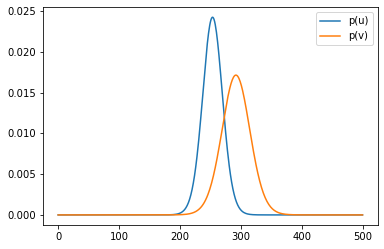

In [17]:
plt.plot(prob_u, label ='p(u)')
plt.plot(prob_v, label ='p(v)')
plt.legend()

Now, we can calculate the Bayesian posterior probability that v>=0 and the corresponding odds.

In [18]:
## calculate posterior probability and odds that v>0

wh_gt=np.where(v >= 0)
p_gt_0=np.sum(prob_v[wh_gt])

wh_lt=np.where(v <= 0)
p_lt_0=np.sum(prob_v[wh_lt])

# this is a cheat to handle the fact that we included the value at 0 in the summation:
p_gt_0 = p_gt_0/(p_gt_0+p_lt_0)

# probability that p>0, as well as odds in favor of that 
print(p_gt_0,p_gt_0/(1-p_gt_0))

0.9588069920348723 23.275964524041523


__Compare the results to the frequentist confidence interval: change the value of `signif` in the code box below until your confidence interval barely excludes 0 to see what significance v<0 is excluded at.__

In [11]:
signif=0.05
tfactor=stats.t.ppf(1-signif/2, 2*ndata-2)
sigma_diff=np.sqrt(sigma1**2+sigma2**2)

print('2-sided Confidence Interval: ',(mean2-mean1)-tfactor*sigma_diff,(mean2-mean1)+tfactor*sigma_diff)

tfactor=stats.t.ppf(1-signif, 2*ndata-2)
print('1-sided Confidence Interval/Upper Limit : ',(mean2-mean1)-tfactor*sigma_diff)


2-sided Confidence Interval:  -0.10466173126553036 1.78445821978928
1-sided Confidence Interval/Upper Limit :  0.055474014891679024


# The likelihood ratio test

A frequentist method with greater statistical power is to evaluate the ratio of the maximum likelihood under $H_0$ and $H_1$, $\Lambda$.  $-2\ln{\Lambda}$ should be distributed as a $\chi^2$ random variable.

In [14]:
wh_0=np.where(v == 0)
wh_gt=np.where(v > 0)
likelihood_ratio=np.max(prob_uv[wh_0,:])/np.max(prob_uv[wh_gt,:])

print('-2 ln of ratio: {:.2f}'.format(-2*np.log(likelihood_ratio)))
print('alpha = 0.05 minimum chi-squared: {:.2f}'.format(stats.chi2.ppf(1-0.05,1)))
print('p-value: {:.2e}'.format((1-stats.chi2.cdf(-2*np.log(likelihood_ratio),1))))

-2 ln of ratio: 3.36
alpha = 0.05 minimum chi-squared: 3.84
p-value: 6.68e-02


# The t test

The classical statistical test for checking if two datasets have the same mean is the t test, which uses a statistic similar to the t we've encountered before.  We calculate the t statistic for the difference of the means of the two datasets; it should follow a t distribution.

In [13]:
# the hard way:
# s=sqrt (((ndata-1.)*sigma1**2*ndata + (ndata-1.)*sigma2**2*ndata)/(2*ndata-2.)*(2./ndata))

# the easy way, since nx=ny:
sigma1=np.std(data1,ddof=1)/np.sqrt(ndata)
sigma2=np.std(data2,ddof=1)/np.sqrt(ndata)

s=np.sqrt(sigma1**2+sigma2**2)
t=(mean2-mean1)/s   # calculate t statistic
print('Value of t: {:.2f}'.format(t))


Value of t: 1.82


## Calculating cutoffs and p values

For a two-sided test, we divide our rejection region between the two tails of the distribution.  We can again use `stats.t.ppf()` to determine cutoffs in t corresponding to our threshold for signficance.

In [20]:
signif=0.05
print(stats.t.ppf(1-signif/2, 2*ndata-2))


2.048407141795244


__Using the below code box, calculate the cutoff in t for a one-tailed test, where we are checking if mean2 is > mean1, without considering a lower value a possibility.__  This is more analogous to our Bayesian test.

In [21]:
signif=0.05
print(stats.t.ppf(1-signif, 2*ndata-2))

1.701130934265931


### Calculating p-values

We can calculate a p-value for our value of t using `stats.t.cdf()`.  Note that we want the probability of getting the observed value of t _or greater_; the CDF integrates from -infinity to x.  

__Using the below code box, calculate the p-value for our value of t for a one-sided test.__

In [25]:
print(1-stats.t.cdf(t,2*ndata-2))

0.039620956672803964


We can save all this work by using `stats.ttest_ind`.  It will only do a two-tailed test, though it can relax the assumption of equal sigmas.

In [26]:
# these turn out to be the same if data2 & data1 have the same size, but in general that doesn't need to be the case.
# it returns a tuple of the t statistic and the p-value.

print(stats.ttest_ind(data2,data1))

print(stats.ttest_ind(data2,data1,equal_var = False))

Ttest_indResult(statistic=1.8214339020311305, pvalue=0.07924191334560793)
Ttest_indResult(statistic=1.8214339020311305, pvalue=0.07968277717750644)


# If you have extra time...

- Try making different realizations of your datasets by rerunning all the cells above and see how the confidence intervals change, how often they include 0, etc.

- make `ndata` larger or smaller and see how your confidence intervals and ability to reject the null hypothesis of zero difference changes.
